In [1]:
# http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
ATTRS_NAME = "lfw_attributes.txt"

# http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
IMAGES_NAME = "lfw-deepfunneled.tgz"

# http://vis-www.cs.umass.edu/lfw/lfw.tgz
RAW_IMAGES_NAME = "lfw.tgz"


In [2]:
import pandas as pd
pd.__version__
import tarfile
from tqdm.notebook import tqdm
import cv2
import os



In [3]:
CODE_SIZE = 1000
DIM_X=40
DIM_Y=40

In [4]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img



In [5]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs



In [6]:
import numpy as np
X, attr = load_lfw_dataset(use_raw=True, dimx=DIM_X, dimy=DIM_Y)
X = X.astype('float32') / 255.0 - 0.5
print(X.max(), X.min())


  0%|          | 0/18983 [00:00<?, ?it/s]

0.5 -0.5


In [7]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))


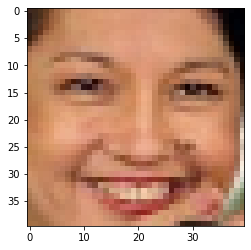

In [8]:
show_image(X[100])


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)


In [10]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    print(img_shape)
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
#     encoder.add(Conv2D(16, kernel_size=3, activation='relu', padding='same', strides=2))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))
#     decoder.add(Conv2DTranspose(16, kernel_size=3, activation='relu', padding='same', strides=2))
#     decoder.add(Conv2D(1,kernel_size=(3,3), activation='sigmoid', padding='same'))


    return encoder, decoder


In [11]:
# # Same as (32,32,3), we neglect the number of instances from shape
# IMG_SHAPE = X.shape[1:]
# # encoder, decoder = build_autoencoder(IMG_SHAPE, CODE_SIZE)

# inp = Input(IMG_SHAPE)
# code = encoder(inp)
# reconstruction = decoder(code)

# autoencoder = Model(inp,reconstruction)
# autoencoder.compile(optimizer='adamax', loss='mse')


# print(autoencoder.summary())


In [16]:
import keras
from keras import Input
from keras.layers import MaxPool2D, UpSampling2D

def build_autoencoder_2(img_shape, code_size):
    print(img_shape)
    
    Max_filter = 32
    Input_img = Input(shape=(DIM_X, DIM_Y, 3))  

    #encoding architecture
    x1 = Conv2D(Max_filter, (3, 3), activation='relu', padding='same')(Input_img)
    x2 = Conv2D(Max_filter//2, (3, 3), activation='relu', padding='same')(x1)
    x2 = MaxPool2D( (2, 2))(x2)
    encoded = Conv2D(Max_filter//4, (3, 3), activation='relu', padding='same')(x2)

    # decoding architecture
    x3 = Conv2D(Max_filter//4, (3, 3), activation='relu', padding='same')(encoded)
    x3 = UpSampling2D((2, 2))(x3)
    x2 = Conv2D(Max_filter//2, (3, 3), activation='relu', padding='same')(x3)
    x1 = Conv2D(Max_filter, (3, 3), activation='relu', padding='same')(x2)
    decoded = Conv2D(3, (3, 3), padding='same')(x1)
        
    autoencoder = Model(Input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

IMG_SHAPE = X.shape[1:]
autoencoder = build_autoencoder_2(IMG_SHAPE, CODE_SIZE)
print(autoencoder.summary())


(40, 40, 3)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 40, 40, 3)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 40, 40, 32)        896       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 40, 40, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 20, 20, 8)         1160      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 20, 20, 8)         584       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 40, 40, 8) 

In [17]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=10,
                validation_data=(X_test, X_test))


Epoch 1/10
370/370 [==============================] - 32s 85ms/step - loss: 0.0112 - val_loss: 0.0020
Epoch 2/10
370/370 [==============================] - 32s 86ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 3/10
370/370 [==============================] - 33s 88ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/10
370/370 [==============================] - 32s 87ms/step - loss: 0.0011 - val_loss: 8.9401e-04
Epoch 5/10
370/370 [==============================] - 32s 88ms/step - loss: 9.0483e-04 - val_loss: 8.2374e-04
Epoch 6/10
370/370 [==============================] - 32s 87ms/step - loss: 8.2827e-04 - val_loss: 7.6170e-04
Epoch 7/10
370/370 [==============================] - 32s 87ms/step - loss: 7.7620e-04 - val_loss: 6.8841e-04
Epoch 8/10
370/370 [==============================] - 32s 87ms/step - loss: 6.9087e-04 - val_loss: 6.8679e-04
Epoch 9/10
370/370 [==============================] - 32s 87ms/step - loss: 6.4516e-04 - val_loss: 6.8384e-04
Epoch 10/10
370/370 [=================

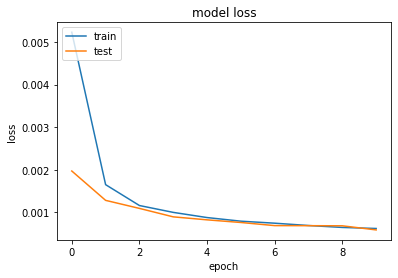

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


(40, 40, 3)
(40, 40, 3)


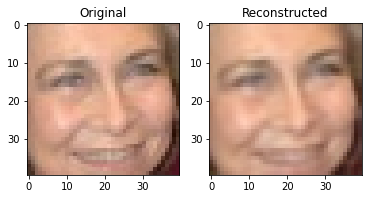

(40, 40, 3)
(40, 40, 3)


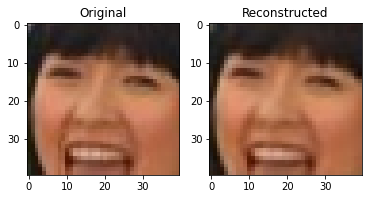

(40, 40, 3)
(40, 40, 3)


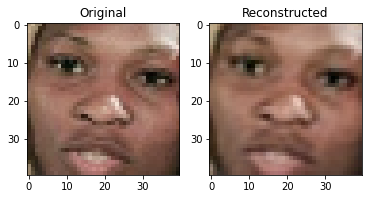

(40, 40, 3)
(40, 40, 3)


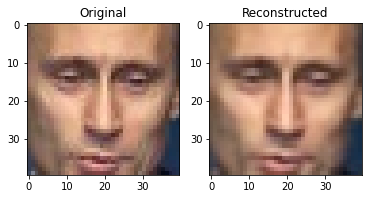

(40, 40, 3)
(40, 40, 3)


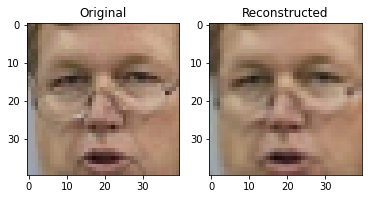

In [28]:
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

    
predictions = autoencoder.predict(X_test)

n = 5
for i in range(n):
    img = X_test[i]
    img_reco = predictions[i]
    
    ssim_none = ssim(img, img, data_range=img.max() - img.min(), multichannel=True)
    ssim_reco = ssim(img, img_reco, data_range=img_reco.max() - img_reco.min(), multichannel=True)
    
    label = 'Similarity Index: {:.2f}'
    
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.xlabel(label.format(ssim_none))
    show_image(img)
    
    plt.subplot(1,2,2)
    plt.title("Reconstructed")
    plt.xlabel(label.format(ssim_reco))
    show_image(img_reco)
    plt.show()
    


TypeError: Invalid shape (1315, 40, 40, 3) for image data

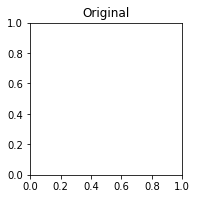

In [22]:
def auto_visualize(img, autoencoder):
    prediction = autoencoder.predict(img)
    
    plt.subplot(1,2,1)
    plt.title("Original")
    show_image(img)
    
    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(prediction)
    plt.show()
    
    
    

def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]
    
    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    code_reshape_factor = 20 # defaults to 2 for CODE_SIZE 32
    plt.imshow(code.reshape([code.shape[-1]//code_reshape_factor,-1]))
    
    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(5):
    img = X_test[i]
    auto_visualize(X_test, autoencoder)
#     visualize(img,encoder,decoder)


In [ ]:
def load_image(filename, dimx=DIM_X, dimy=DIM_Y):
    with open(filename, 'rb') as f:
        img = decode_image_from_raw_bytes(f.read())
        img = cv2.resize(img, (dimx, dimy))
        img = img.astype('float32') / 255.0 - 0.5
        return img


In [ ]:
filename = 'C:/Users/Jhehey/fiftyone/caltech256/cartman/032_0009.jpg'
img = load_image(filename)

show_image(img)

# for img in imgs:
visualize(img,encoder,decoder)


In [ ]:
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

def show_similarity(img, encoder, decoder):
    code = encoder.predict(img[None])[0]
    img_reco = decoder.predict(code[None])[0]
    
    ssim_none = ssim(img, img, data_range=img.max() - img.min(), multichannel=True)
    ssim_reco = ssim(img, img_reco, data_range=img_reco.max() - img_reco.min(), multichannel=True)

    
    label = 'Similarity Index: {:.2f}'
    
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.xlabel(label.format(ssim_none))
    show_image(img)
    
    plt.subplot(1,2,2)
    plt.title("Reconstructed")
    plt.xlabel(label.format(ssim_reco))
    show_image(img_reco)
    plt.show()
    
show_similarity(img, encoder, decoder)

In [ ]:
def apply_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise


In [ ]:
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])


In [ ]:

# We can use bigger code size for better quality
encoder, decoder = build_autoencoder(IMG_SHAPE, code_size=CODE_SIZE)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)

    # We continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=(X_test_noise, X_test))


In [ ]:
X_test_noise = apply_gaussian_noise(X_test)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)
    


In [ ]:
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

def show_similarity(img, encoder, decoder):
    code = encoder.predict(img_noise[None])[0]
    img_reco = decoder.predict(code[None])[0]
    
    ssim_none = ssim(img, img, data_range=img.max() - img.min(), multichannel=True)
    ssim_reco = ssim(img, img_reco, data_range=img_reco.max() - img_reco.min(), multichannel=True)

    
    label = 'Similarity Index: {:.2f}'
    
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.xlabel(label.format(ssim_none))
    show_image(img)
    
    plt.subplot(1,2,2)
    plt.title("Reconstructed")
    plt.xlabel(label.format(ssim_reco))
    show_image(img_reco)
    plt.show()


def show_similarity_noisy(img, img_noise, encoder, decoder):
    code = encoder.predict(img_noise[None])[0]
    img_reco = decoder.predict(code[None])[0]
    
    ssim_none = ssim(img, img, data_range=img.max() - img.min(), multichannel=True)

    ssim_noise = ssim(img, img_noise, data_range=img_noise.max() - img_noise.min(), multichannel=True)
    
    ssim_reco = ssim(img, img_reco, data_range=img_reco.max() - img_reco.min(), multichannel=True)
    
    label = 'Similarity Index: {:.2f}'
    
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.xlabel(label.format(ssim_none))
    show_image(img)
    
    plt.subplot(1,3,2)
    plt.title("Noisy Image")
    plt.xlabel(label.format(ssim_noise))
    show_image(img_noise)
    
    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.xlabel(label.format(ssim_reco))
    show_image(img_reco)
    plt.show()

for i in range(5):
    img = X_test[i]
    img_noise = X_test_noise[i]
    show_similarity_noisy(img,img_noise,encoder,decoder)
